来源：https://wiseodd.github.io/techblog/2017/12/23/annealed-importance-sampling/

### 重要性采样简介

$E_{x\sim p(x)}[f(x)]=\int p(x)f(x)dx = \int q(x)\frac{p(x)}{q(x)}f(x)dx=E_{x\sim q(x)}[\frac{p(x)}{q(x)}f(x)]\\= \frac{1}{N}\sum_{i=1,x_i\sim q(x)}^N \frac{p(x_i)}{q(x_i)}f(x_i)$

$p(x)$称为target distribution，$q(x)$称为proposal distribution。

重要性采样的算法大致如下：首先从q中采集N个样本，计算各样本的概率$q(x_i)$；然后将这N个样本带入p中得到$p(x_i)$。于是$w_i=\frac{p(x_i)}{q(x_i)}$就是每个$f(x_i)$的新权重，称为importance weight。

代码实现如下。假设我们想要估计Beta分布（target distribution）。从中取样很难，但我们可以计算其在某点的值。这里以均匀分布作为proposal distribution，这也意味着我们对target distribution没有任何认知。

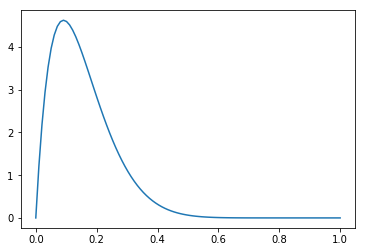

In [95]:
from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np

# beta分布的参数
a = 2
b = 11

x = np.linspace(0, 1, 100)
plt.plot(x, beta.pdf(x, a, b))

In [104]:
N = 10000

samples = np.random.rand(N,1)                    # 随机生成服从U(0,1)的N个样本

weights = 1                                      # q(x_i) = 1/(1-0) = 1（千万小心）
eval_pdf = beta.pdf(samples, a, b)               # x_i ~ Beta(a,b)，eval_pdf为p(x_i)
importance_w = eval_pdf / weights                # importance weight

w = importance_w / sum(importance_w)             # 对权重进行归一化操作

这些可以看出这些importance weight的分布形状与target distribution的分布形状一样。

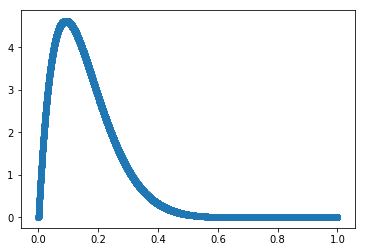

In [105]:
plt.scatter(samples, importance_w)

In [106]:
# 该Beta分布的均值约为0.1538  a/(a+b)

mean = beta.stats(a, b, moments='m')
print(mean)

0.15384615384615385


In [107]:
# 下面使用重要性采样来计算该均值 E(x)

is_mean = sum(samples * importance_w) / N
print(is_mean)

[0.15421186]


### AIS简介

假设由这样的分布：

$p(x)=\frac{1}{Z}f(x)$，$Z=\sum_{x} f(x)$

当维度很高时，求$Z$的这种求和操作时不可行的，因为可能有指数个项相加。

$E_{p(x)}[x]=\sum_{x}xp(x)$

若不知道$p(x)$，自然无法计算该期望。此时一种可取的方法是使用重要性采样，用另一个分布$q(x)$来近似$p(x)$。但确定合适的$q(x)$是比较困难的，这就是退火重要性采样（Annealed Importance Sampling，AIS）背后的动机。

### AIS的大致过程

假设target distribution为$p_0(x)\propto f_0(x)$，proposal distribution为$p_n(x)\propto f_n(x)$。我们想要一系列中间分布$p_j(x)\propto f_j(x)$作为连接target distribution和proposal distribution的桥梁。这些中间分布以“退火”的方式进行选择：

![ais_1](ais_5.PNG)

其中$1=\beta_0 > \beta_1 > \cdots > \beta_n = 0$。

在采样过程中，AIS使用的是MCMC法，相当于我们希望从proposal distribution出发，让采样的点一步步走向target distribution。

![ais](ais_2.PNG)

转移矩阵$T$所对应的接受率为：（这个式子的直观含义是：对x施加一个扰动得到x’，这就是一次转移，如果x'在$f_j$上得分更高，说明应该接受这次转移，故接受率定义如此）

![ais](ais_6.PNG)

得到样本点$x_{n-1},x_{n-2},\cdots,x_1,x_0$后，每个点所对应的权重定义如下：（这个式子的直观含义是，每一项可以看成是对一次转移的“评分”，“评分”越高说明这次转移越成功，转移得到的点越可能出现在新分布中，最后的权重就是这些评分的积，可以想象权重越大，则最后的点$x_0$越可能在target distribution中）

![ais](ais_3.PNG)

所以最终的期望为：

![ais](ais_4.PNG)

### 代码实现

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt


def f_0(x):
    """ 
        目标分布（我们真正想从中采样的分布）
        Target distribution -- 正比于 N(-5, 2) 
    """
    return np.exp(-(x+5)**2/(2 * 2**2))

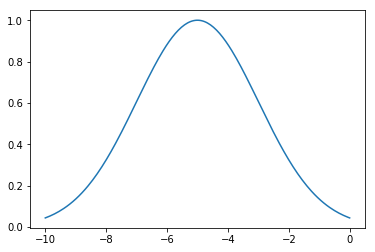

In [3]:
# 目标分布N(-5,2)所对应的函数的图像

x = np.linspace(-10, 0, 200)

plt.plot(x, f_0(x))

In [11]:
# proposal distribution N(0,1)
p_n = st.norm(0, 1)

def f_n(x):
    return np.exp(-x**2 / 2)


def f_j(x, beta):
    """ 
        中间分布，使用退火模式
        Intermediate distribution: interpolation between f_0 and f_n 
    """
    return f_0(x)**beta * f_n(x)**(1-beta)

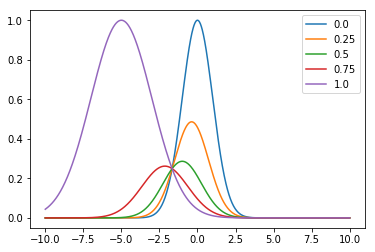

In [19]:
"""
    下面的展示了一系列的中间分布
"""

for idx, beta in enumerate(np.linspace(0,1,5)):
    x = np.linspace(-10, 10, 1000)
    f_x = f_j(x, beta)
    
    plt.plot(x, f_x, label=str(beta))
    
plt.legend()

下面定义转移函数$T_{j}(x,x')$：

In [20]:
def T(x, f, n_steps=10):
    """ 
        Transition distribution: T(x'|x) 
        using n-steps Metropolis sampler
        
        初始点为x，进行n_steps次转移，希望得到以最大可能出现在f中的新点
    """
    for t in range(n_steps):
        # Proposal
        x_prime = x + np.random.randn()  # 施加一个扰动，得到一个新点

        # Acceptance prob
        a = f(x_prime) / f(x)            # 计算接受率，接受率越高说明新点
                                         # 越有可能出现在分布f中
        if np.random.rand() < a:         # 若接受率足够高，则接受这次转移
            x = x_prime

    return x

下面就可以进行采样了：

In [28]:
"""
    总共要产生n_samples个样本点
    最初这些样本点从proposal distribution中采样
    
    然后对每个样本点进行len(betas)轮迁移，每轮迁移的目标是让点从符合上个中间分布的
    位置转移到符合下个分布的位置
    
    可以想象，最后，转移的结果就是这些点会较好的符合target distribution
""" 

# 共48个中间分布，加上target distribution和proposal distribution共50个
n_iter = 50
betas = np.linspace(0, 1, n_iter)

# Sampling，一共采样100个点
n_samples = 100
samples = np.zeros(n_samples)
weights = np.zeros(n_samples)

# 进行n_samples轮采样，每轮产生一个样本点及其对应权重
for t in range(n_samples):
    # 从proposal distribution中采样得到初始点x，初始权重为1
    x = p_n.rvs()
    w = 1
    
    for n in range(1, len(betas)):
        # 点从符合上个中间分布的位置转移到符合下个中间分布的位置
        x = T(x, lambda x: f_j(x, betas[n]), n_steps=5)
        
        # 计算这个x对应的权重，这里先取log，避免溢出
        # w *= f_{n-1}(x_{n-1}) / f_n(x_{n-1})
        w += np.log(f_j(x, betas[n])) - np.log(f_j(x, betas[n-1]))

    # 记录本轮采样的样本及其权重
    samples[t] = x
    weights[t] = np.exp(w)

有了这些样本点及权重，就可以算期望了：

In [29]:
1/np.sum(weights) * np.sum(weights * samples)

-5.475405509976224